In [1]:
## Celiac vs EE vs Normal

In [2]:
#--------------FOR REFERENCE, THIS IS AN OLD SCRIPT, DO NOT USE, INTENTIONALLY THROWING AN ERROR HERE---------# 
1
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import skimage
from skimage.transform import*

/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "/scratch/kk4ze/data_lowres_2200x2200_augmented_duplicated/"
sz = 2200
arch = resnet34
bs = 4

In [3]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),bs=2)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 132/132 [00:44<00:00,  3.13it/s]


In [4]:
learn.fit(0.0003, 15)

epoch      trn_loss   val_loss   accuracy                      
    0      0.995469   0.713304   0.738636  
    1      0.912209   0.632297   0.768939                      
    2      0.931748   0.594133   0.810606                      
    3      0.921143   0.520394   0.840909                      
    4      0.831254   0.544592   0.825758                      
    5      0.902544   0.511816   0.852273                      
    6      0.864165   0.547121   0.818182                      
    7      0.749421   0.523852   0.859848                      
    8      0.70688    0.555903   0.768939                      
    9      0.781914   0.565775   0.780303                      
    10     0.77512    0.548908   0.772727                      
    11     0.891781   0.498414   0.829545                      
    12     0.844017   0.528527   0.833333                      
    13     0.727893   0.547205   0.772727                      
    14     0.834529   0.462317   0.833333                   

[0.46231667697429657, 0.8333333333333334]

 56%|█████▌    | 322/574 [00:00<00:00, 528.80it/s, loss=2.81]


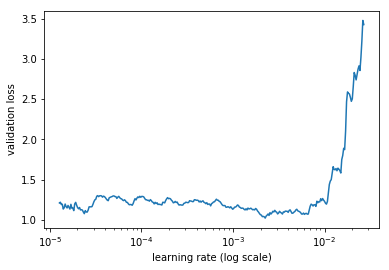

In [5]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
learn.sched.plot()

In [4]:
m = arch(True)

In [7]:
m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [6]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512,512,3,3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn = ConvLearner.from_model_data(m, data)

In [ ]:
# tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
# # Visualising the augmentation
# def get_augs():
#     data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
#     x,_ = next(iter(data.aug_dl))
#     return data.trn_ds.denorm(x)[1]
# ims = np.stack([get_augs() for i in range(6)])
# plots(ims, rows=2)


In [ ]:
# data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
# learn = ConvLearner.from_model_data(m, data)

In [9]:
learn.freeze_to(-4)

In [10]:
m[-1].trainable

True

In [11]:
m[-4].trainable

True

In [ ]:
learn.fit(0.0003, 10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.716423   0.75096    0.700758  
    1      0.612132   0.72161    0.693182                    
  1%|▏         | 4/287 [00:05<07:50,  1.66s/it, loss=0.611]

In [ ]:
learn.save('2200_lowres_resnet34_staintools_duplicated_CAM')

## Class Activation Maps (CAM)

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [ ]:
x,y = next(iter(data.val_dl))

In [ ]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

In [ ]:
x[0][1]

In [ ]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [ ]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [ ]:
%time py = m(Variable(x.cuda()))

In [ ]:
for o in sfs: o.remove()

In [ ]:
[o.features.size() for o in sfs]

In [ ]:
py = np.exp(to_np(py)[0]); py

In [ ]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

In [ ]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

In [ ]:
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');

In [ ]:
log_preds = learn.predict()
log_preds.shape

In [ ]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

In [ ]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Normal')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
y = data.val_y

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Model

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [ ]:
learn.fit(lr, 2, cycle_len=1)

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

In [ ]:
learn.fit(lr, 2, cycle_len=1)

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)